<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/tasks/speech-enhancement-from-scratch.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/tasks/speech-enhancement-from-scratch.ipynb)

# Speech Enhancement From Scratch

So you want to do regression tasks with speech? Look no further, you're in the right place. This tutorial will walk you through a basic speech enhancement template with SpeechBrain to show all the components needed for making a new recipe.



Before jumping into the code, let's introduce a bit the problem of speech enhancement. The goal of speech enhancement is to remove noise from an input recording:

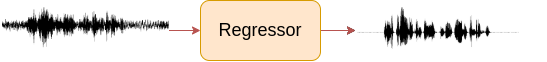

The problem is very hard because of the huge variety of disturbances that might corrupt speech signals.


There are different ways to approach the problem. Nowadays, one of the most popular technique is masked-based speech enhancement:

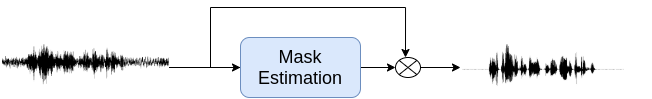

In masking approaches, rather than estimating the enhanced signal directly, we estimate a soft mask. We then estimate the enhanced signal by multiplying the noisy one by the soft mask.

Depending on the type of input/output we can have:
- Waveform masking (depicted in the figure above)
- Spectral masking (depicted in the figure below)



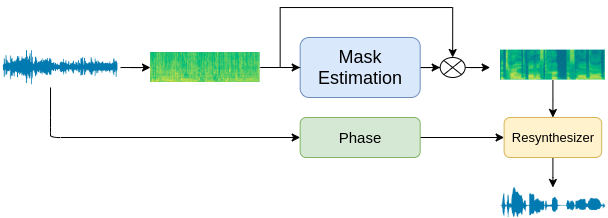

In spectral masking, the system maps noisy spectrograms into clean ones. This mapping is generally considered easier than waveform-to-waveform mapping. However, retrieving the signal in the time domain requires adding the phase information. The common solution (reasonable, but not ideal) consists to use the phase of the noisy signal.  Waveform-masking approaches do not suffer from this limitation and are progressively gaining popularity within the community.

It is worth mentioning that SpeechBrain currently supports even more advanced solutions for speech enhancement such as [MetricGAN+](https://arxiv.org/abs/2104.03538) (that learns the PESQ metric within an adversarial training framework) and [MimicLoss](https://github.com/speechbrain/speechbrain/tree/develop/recipes/Voicebank/MTL/ASR_enhance) (that achieves better enhancement using the information derived from a speech recognizer).



In this tutorial, we will guide you through the creation of a simple speech enhancement system based on spectral masking.

In particular, we will refer to the example reported here:

<https://github.com/speechbrain/speechbrain/blob/develop/templates/enhancement/>

The README provides a nice introduction, so it is reproduced here:

==========================

This folder provides a working, well-documented example for training a speech enhancement model from scratch, based on a few hours of data. The data we use is from Mini Librispeech + OpenRIR.

There are four files here:

 * `train.py`: the main code file, outlines entire training process.
 * `train.yaml`: the hyperparameters file, sets all parameters of execution.
 * `custom_model.py`: A file containing the definition of a PyTorch module.
 * `mini_librispeech_prepare.py`: If necessary, downloads and prepares data manifests.

To train an enhancement model, just execute the following on the command-line:

    python train.py train.yaml --data_folder /path/to/save/mini_librispeech

This will automatically download and prepare the data manifest for mini librispeech, and then train a model with dynamically generated noisy samples, using noise, reverberation, and babble.

=========================

So to start, let's make sure we can just run the template without modifications.

In [ ]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

# Clone SpeechBrain repository
!git clone https://github.com/speechbrain/speechbrain/

In [ ]:
import speechbrain as sb

In [ ]:
%cd speechbrain/templates/enhancement
!python train.py train.yaml --device='cpu' --debug

## Recipe overview in Train.py

Let's start with the highest-level view of the recipe and work our way down. To do this, we should look at the bottom of the recipes where the `if __name__ == "__main__":` block defines the recipe structure. The basic process is:

1. Load hyperparameters and command line overrides.
2. Prepare data manifests and loading objects.
3. Instantiate `SEBrain` sub-class as `se_brain`.
4. Call `se_brain.fit()` to perform training.
5. Call `se_brain.evaluate()` to check final performance.

And that's it! Before we go and actually run this code, let's manually define the `SEBrain` sub-class of the `Brain` class. If you want a more in-depth tutorial about how the `Brain` class works, checkout the [Brain tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/brain-class.html).

For simplicity, we'll just define the sub-class with just the first method override and then add the other overrides one-by-one. The first method is the `compute_forward` method which simply defines how the data is used by the model to make predictions. The return values should include any predictions made by the model. For this case specifically, the method computes the relevant features, computes a predicted mask, then applies the mask and re-computes time-domain signals.

In [ ]:
class SEBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Apply masking to convert from noisy waveforms to enhanced signals.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : dict
            A dictionary with keys {"spec", "wav"} with predicted features.
        """

        # We first move the batch to the appropriate device, and
        # compute the features necessary for masking.
        batch = batch.to(self.device)
        self.clean_wavs, self.lens = batch.clean_sig

        noisy_wavs, self.lens = self.hparams.wav_augment(
            self.clean_wavs, self.lens
        )

        noisy_feats = self.compute_feats(noisy_wavs)

        # Masking is done here with the "signal approximation (SA)" algorithm.
        # The masked input is compared directly with clean speech targets.
        mask = self.modules.model(noisy_feats)
        predict_spec = torch.mul(mask, noisy_feats)

        # Also return predicted wav, for evaluation. Note that this could
        # also be used for a time-domain loss term.
        predict_wav = self.hparams.resynth(
            torch.expm1(predict_spec), noisy_wavs
        )

        # Return a dictionary so we don't have to remember the order
        return {"spec": predict_spec, "wav": predict_wav}

If you're wondring here what the `self.modules` and `self.hparams` objects are, you're asking the right questions. These objects are constructed when the `SEBrain` class is instantiated, and come directly from the `dict` arguments to the initializer: `modules` and `hparams`. The keys to the dict provide the name that you use to reference the object, e.g. passing `{"model": model}` for `modules` would allow you to access the model with `self.modules.model`.

The other method that is required to be defined in a `Brain` sub-class is the `compute_objectives` function. We sub-class `SEBrain` itself just to provide a convenient way to split up the class definition, don't use this technique in production code!

In [ ]:
class SEBrain(SEBrain):
    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : dict
            The output dict from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Prepare clean targets for comparison
        clean_spec = self.compute_feats(self.clean_wavs)

        # Directly compare the masked spectrograms with the clean targets
        loss = sb.nnet.losses.mse_loss(
            predictions["spec"], clean_spec, self.lens
        )

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id,
            predictions["spec"],
            clean_spec,
            self.lens,
            reduction="batch",
        )

        # Some evaluations are slower, and we only want to perform them
        # on the validation set.
        if stage != sb.Stage.TRAIN:

            # Evaluate speech intelligibility as an additional metric
            self.stoi_metric.append(
                batch.id,
                predictions["wav"],
                self.clean_wavs,
                self.lens,
                reduction="batch",
            )

        return loss

Both of these methods use a third method that is not an override called `compute_feats`, we'll quickly define it here:

In [ ]:
class SEBrain(SEBrain):
    def compute_feats(self, wavs):
        """Returns corresponding log-spectral features of the input waveforms.

        Arguments
        ---------
        wavs : torch.Tensor
            The batch of waveforms to convert to log-spectral features.
        """

        # Log-spectral features
        feats = self.hparams.compute_STFT(wavs)
        feats = sb.processing.features.spectral_magnitude(feats, power=0.5)

        # Log1p reduces the emphasis on small differences
        feats = torch.log1p(feats)

        return feats

There's only two more methods defined, which are used to keep track of statistics and save checkpoints. These are the `on_stage_start` and `on_stage_end` methods, and they're called by `fit()` before and after iterating each dataset respectively. Before each stage, we set up the metric trackers:

In [ ]:
class SEBrain(SEBrain):
    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.mse_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.stoi_metric = sb.utils.metric_stats.MetricStats(
                metric=sb.nnet.loss.stoi_loss.stoi_loss
            )

After the validation stage, we use the trackers to summarize the stats, and save a checkpoint.

In [ ]:
class SEBrain(SEBrain):
    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "stoi": -self.stoi_metric.summarize("average"),
            }

        # At the end of validation, we can write stats and checkpoints
        if stage == sb.Stage.VALID:
            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            # unless they have the current best STOI score.
            self.checkpointer.save_and_keep_only(meta=stats, max_keys=["stoi"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )

Okay, that's everything you need to define the `SEBrain` class! The only thing left before we can actually run this thing is the data loading functions. We'll use `DynamicItemDatasets` which you can learn more about in the [Tutorial on Data Loading](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/data-loading-pipeline.html). We need only to define the function that loads audio data, and we can use that to create all our datasets!

In [ ]:
def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json` and `valid.json` manifest files are available.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Define audio pipeline. Adds noise, reverb, and babble on-the-fly.
    # Of course for a real enhancement dataset, you'd want a fixed valid set.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("clean_sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""
        clean_sig = sb.dataio.dataio.read_audio(wav)
        return clean_sig

    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    hparams["dataloader_options"]["shuffle"] = False
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            replacements={"data_root": hparams["data_folder"]},
            dynamic_items=[audio_pipeline],
            output_keys=["id", "clean_sig"],
        ).filtered_sorted(sort_key="length")
    return datasets


Now that we've defined all the code in `train.py` other than the `__main__` block, we can start running our recipe! This code is edited slightly to simplify the parts that don't necessarily apply to running the code in Colab. The first step is to load the hyperparameters. This creates a bunch of the needed objects automatically. You can find more info about how `HyperPyYAML` works in our [HyperPyYAML tutorial](https://speechbrain.readthedocs.io/en/latest/tutorials/basics/hyperpyyaml.html). In addition, we'll create the folder for storing experimental data, checkpoints and statistics.

In [ ]:
from hyperpyyaml import load_hyperpyyaml
with open("train.yaml") as fin:
  hparams = load_hyperpyyaml(fin)
sb.create_experiment_directory(hparams["output_folder"])

As easily as that, we have access to our pytorch model, among many other hyperparameters. You can explore the `hparams` object at your leisure, but here's a few examples:

In [ ]:
# Already-applied random seed
hparams["seed"]

In [ ]:
# STFT function
hparams["compute_STFT"]

In [ ]:
# Masking model
hparams["model"]

Prepare the data manifests and create the dataset objects using them with the function we defined earlier:

In [ ]:
from mini_librispeech_prepare import prepare_mini_librispeech
prepare_mini_librispeech(
  data_folder=hparams["data_folder"],
  save_json_train=hparams["train_annotation"],
  save_json_valid=hparams["valid_annotation"],
  save_json_test=hparams["test_annotation"],
)
datasets = dataio_prep(hparams)

We can check that the data is being loaded correctly by seeing the first items:

In [ ]:
import torch
datasets["train"][0]

In [ ]:
datasets["valid"][0]

Instantiate the SEBrain object to prepare for training:

In [ ]:
se_brain = SEBrain(
  modules=hparams["modules"],
  opt_class=hparams["opt_class"],
  hparams=hparams,
  checkpointer=hparams["checkpointer"],
)

And then call `fit()` to do the training! The `fit()` method iterates the training loop, calling the methods necessary to update the parameters of the model. Since all objects with changing state are managed by the Checkpointer, training can be stopped at any point, and will be resumed on next call.

In [ ]:
se_brain.fit(
  epoch_counter=se_brain.hparams.epoch_counter,
  train_set=datasets["train"],
  valid_set=datasets["valid"],
  train_loader_kwargs=hparams["dataloader_options"],
  valid_loader_kwargs=hparams["dataloader_options"],
)

Once training is complete, we can load the checkpoint that had the best performance on validation data (as measured by STOI) to evaluate.

In [ ]:
se_brain.evaluate(
  test_set=datasets["test"],
  max_key="stoi",
  test_loader_kwargs=hparams["dataloader_options"],
)

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```